
## Install instruction

1. FABM install instructions using conda: https://github.com/fabm-model/fabm/wiki/GOTM


2. To run in a notebook
- `conda activate fabm`
- `conda install ipykernel`
- `python -m ipykernel install --user --name=fabm --display-name "Python (fabm)"`

3. Next type `jupyter-notebook` and select the fabm kernel

4. Make sure the following packages are installed in your pip manager
- `pip install ipywidgets`
- `pip install scipy`
- `pip install matplotlib`


In [3]:
import os
import glob
import ipywidgets
import scipy.integrate

# Note: "%matplotlib widget" below enables interactive plots but requires https://github.com/matplotlib/ipympl
# Alternatively you could use "%matplotlib notebook" (interactive but deprecated) or "%matplotlib inline" (static plots)
%matplotlib
import matplotlib.pyplot

Using matplotlib backend: module://ipympl.backend_nbagg


In [4]:
# Show available test cases
testcases = [(os.path.basename(path)[:-5], path) for path in glob.glob("../*.yaml")]
testcase_dropdown = ipywidgets.Dropdown(options=testcases, description="Test case:")
display(testcase_dropdown)

Dropdown(description='Test case:', options=(('fabm-gotm-ergom', '../fabm-gotm-ergom.yaml'), ('fabm-uhh-phy_fee…

In [5]:
# Initialize the test case (this reads fabm.yaml)
import pyfabm

model = pyfabm.Model(testcase_dropdown.value)

Initializing ergom...
   model type: gotm/ergom
   initialization succeeded.


In [6]:
# Present configurable environmental conditions
bottom_depth = 10
default_environment = {
    "temperature": 15.0,
    "practical_salinity": 35.0,
    "surface_downwelling_photosynthetic_radiative_flux": 50.0,
    "downwelling_photosynthetic_radiative_flux": 10.0,
    "density": 1025.0,
    "mole_fraction_of_carbon_dioxide_in_air": 414.2,
    "bottom_depth": bottom_depth,
    "depth": 0.5 * bottom_depth,
    "pressure": 0.5 * bottom_depth,
    "cell_thickness": bottom_depth,
}
model.cell_thickness = bottom_depth  # cell thickness in m, used by getRates to scale surface and bottom fluxes
labels, inputs, units = [], [], []
for variable in model.dependencies:
    labels.append(ipywidgets.Label("%s:" % variable.long_name))
    inputs.append(
        ipywidgets.FloatText(
            value=default_environment.get(variable.name, 0.0), layout={"width": "7em"}
        )
    )
    units.append(ipywidgets.Label("%s" % variable.units))
display(
    ipywidgets.HBox(
        (
            ipywidgets.VBox([ipywidgets.HTML("<b>Variable</b>")] + labels),
            ipywidgets.VBox([ipywidgets.HTML("<b>Value</b>")] + inputs),
            ipywidgets.VBox([ipywidgets.HTML("<b>Units</b>")] + units),
        )
    )
)

In [7]:
# Transfer environmental conditions to model
for variable, widget in zip(model.dependencies, inputs):
    variable.value = widget.value

# Initialize model (this also verifies that all dependencies have been fulfilled)
assert model.start(), "Model failed to start: %s" % pyfabm.getError()

In [8]:
# Time derivative
def dy(t, y):
    model.state[:] = y
    return model.getRates(t)


# Time-integrate over 200 days (note: FABM's internal time unit is seconds!)
result = scipy.integrate.solve_ivp(
    dy, [0.0, 200.0 * 86400], model.state, first_step=3600.0, max_step=86400.0
)

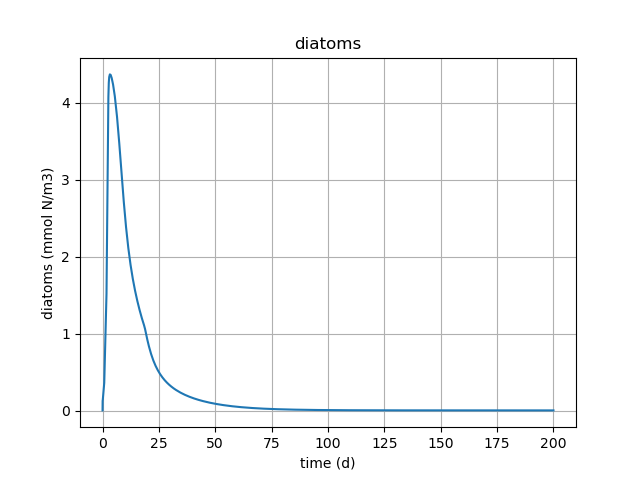

In [9]:
# Plot results
matplotlib.pyplot.ioff()
fig = matplotlib.pyplot.figure()
ax = fig.gca()
(line,) = ax.plot(result.t / 86400, result.y[0, :])
ax.grid()
ax.set_xlabel("time (d)")


def update(variable):
    v = model.state_variables[variable]
    line.set_ydata(result.y[variable, :])
    ax.set_ylabel("%s (%s)" % (v.long_name, v.units))
    ax.set_title(v.long_name)
    ax.relim()
    ax.autoscale()
    fig.canvas.draw()


dropdown = ipywidgets.interactive(
    update,
    variable=[
        (variable.long_path, i) for i, variable in enumerate(model.state_variables)
    ],
)
display(dropdown)
fig.show()